# Figure 5: tracking holes in the MCF10A epithelial monolayer after doxorubicin treatment

Dataset `MCF10A_TimeLapse_Chemotherapy\2021-07-02_MCF10Amut_H2B-ERKKTRturq-FoxoNGreen_Doxorubicin_20x_T5min`

## Definitions

In [1]:
import os
import gc
import glob
import pickle

import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import stats
import math

import napari
from napari_timestamper import render_as_rgb, save_image_stack

from arcos4py.tools import track_events_image

# TIFF stacks I/O
from tifffile import imread, imwrite

from skimage import io
from skimage import measure
from skimage.util import map_array
from skimage.morphology import binary_opening, square
from skimage.measure import regionprops, regionprops_table

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# set font to arial
plt.rcParams['font.sans-serif'] = "Arial"
sns.set_theme(style='white')

import plotnine as p9
from mizani.formatters import percent_format



In [36]:
288*5/60

24.0

In [ ]:
IMG_NAPARI = True  # Whether to show images in napari
DATA_SAVE = True  # Whether to save intermediate data
PLOT_SAVE = True # Whether to save plots

DIR_CORE = "../../data/5_hole_tracking"
DIR_IN = f"{DIR_CORE}/input-data"
DIR_TMP = f"{DIR_CORE}/output-data"
DIR_OUT_PLOT = f"{DIR_CORE}/output-plots"
DIR_OUT_VIDEO = f"{DIR_CORE}/output-videos"
DIR_TMP = "/tmp"

PXSZ = 664.66 / 1024  # pixel size in um
SAMPLE_PERIOD_MIN = 5 # sample period in minutes

colpal = [(0.298, 0.447, 0.690),
          (0.867, 0.518, 0.322),
          (0.333, 0.659, 0.408),
          (0.769, 0.306, 0.322)]

# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert RGB colors in colpal to hex format
colpal_hex = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in colpal]

v_cond_order = ["Control", "Low", "Medium", "High"]

def filter_tracks_vec(tracks, threshold):
    # Initialize a dictionary to hold the count of unique track IDs per frame
    track_id_counts = {}

    # Iterate over each frame and count each unique track ID only once per frame
    for frame in range(tracks.shape[0]):
        unique_track_ids_in_frame = np.unique(tracks[frame])
        for track_id in unique_track_ids_in_frame:
            if track_id == 0:  # Skip the background track ID
                continue
            if track_id not in track_id_counts:
                track_id_counts[track_id] = 1
            else:
                track_id_counts[track_id] += 1

    # Identify track_ids that meet the threshold requirement
    valid_track_ids = [track_id for track_id, count in track_id_counts.items() if count > threshold]

    # Create a mask for valid track_ids
    mask = np.isin(tracks, valid_track_ids)

    # Apply the mask to filter tracks, setting invalid tracks to 0
    filtered_tracks = np.where(mask, tracks, 0)

    return filtered_tracks

def median_confidence_interval(data, confidence=0.95, method='bootstrap', n_bootstrap=1000, random_state=None):
    """
    Calculate the confidence interval for the median.
    
    Parameters:
    -----------
    data : array-like
        Input data
    confidence : float, optional
        Confidence level (default: 0.95 for 95% confidence interval)
    method : str, optional
        Method to use: 'bootstrap' or 'binomial' (default: 'bootstrap')
    n_bootstrap : int, optional
        Number of bootstrap samples if using 'bootstrap' method (default: 1000)
    random_state : int or None, optional
        Random seed for reproducibility (default: None)
        
    Returns:
    --------
    tuple
        (median, lower_bound, upper_bound)
    """
    data = np.asarray(data)
    n = len(data)
    median = np.median(data)
    
    if method == 'bootstrap':
        # Bootstrap method
        if random_state is not None:
            np.random.seed(random_state)
            
        bootstrap_medians = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=n, replace=True)
            bootstrap_medians.append(np.median(sample))
        
        # Calculate percentile interval
        alpha = (1 - confidence) / 2
        lower_bound = np.percentile(bootstrap_medians, 100 * alpha)
        upper_bound = np.percentile(bootstrap_medians, 100 * (1 - alpha))
        
    elif method == 'binomial':
        # Binomial method based on order statistics
        alpha = (1 - confidence) / 2
        
        # Find the rank positions for the confidence interval
        # Using exact binomial interval
        j = stats.binom.ppf(alpha, n, 0.5)
        k = stats.binom.ppf(1 - alpha, n, 0.5)
        
        # Convert to integer ranks and handle edge cases
        j = max(0, int(j))
        k = min(n - 1, int(k))
        
        # Sort the data and extract the values at these ranks
        sorted_data = np.sort(data)
        lower_bound = sorted_data[j]
        upper_bound = sorted_data[k]
        
    else:
        raise ValueError("Method must be either 'bootstrap' or 'binomial'")
        
    return median, lower_bound, upper_bound

def interpret_cohens_d(d):
    """Interpret the magnitude of Cohen's d effect size"""
    d = abs(d)  # Take absolute value for interpretation
    if d < 0.2:
        return 'negligible'
    elif d < 0.5:
        return 'small'
    elif d < 0.8:
        return 'medium'
    else:
        return 'large'
    
def remap_segmentation(
    df: pd.DataFrame,
    segmentation: list,
    timepoint_column: str = "timepoint",
    label_column: str = "label",
    measure_column: str = "ERK",
) -> list:
    tracked_numpy = df[[timepoint_column, label_column, measure_column]].sort_values(timepoint_column).to_numpy()
    grouped_numpy = np.split(tracked_numpy, np.unique(tracked_numpy[:, 0], return_index=True)[1][1:])
    ratio_remapped = []
    for img, grp in zip(segmentation, grouped_numpy):
        img_copy = map_array(img, grp[:, 1], grp[:, 2])
        ratio_remapped.append(img_copy)
    return ratio_remapped

In [3]:
# Create directories for outputting plots and data

if not os.path.exists(DIR_TMP):
    os.makedirs(DIR_TMP)
    print(f"Directory {DIR_TMP} created successfully!")
else:
    print(f"Directory {DIR_TMP} already exists!")

if not os.path.exists(DIR_OUT_PLOT):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_PLOT} created successfully!")
else:
    print(f"Directory {DIR_OUT_PLOT} already exists!")

if not os.path.exists(DIR_OUT_VIDEO):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_VIDEO} created successfully!")
else:
    print(f"Directory {DIR_OUT_VIDEO} already exists!")

Directory /tmp already exists!
Directory ../../data/5_hole_tracking/output-plots already exists!
Directory ../../data/5_hole_tracking/output-videos already exists!


## Load data

In [4]:
im_raw_path = f"{DIR_IN}/raw/"
im_seg_path = f"{DIR_IN}/segmented_holes/"

In [5]:
# List of all available FOVs

included_extensions = ['tif','tiff', 'TIF', 'TIFF']
im_raw_files = [fn for fn in os.listdir(im_raw_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

im_seg_files = [fn for fn in os.listdir(im_seg_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

im_raw_files.sort()
im_seg_files.sort()

## Show a single time-lapse in napari

Showing a single FOV treated with a high dosage, 5uM, of doxorubicin (file: '32_Ori.tif').

In [111]:
# Read a single FOV
n_fov_sel = 0
im_raw = io.imread(im_raw_path + im_raw_files[n_fov_sel])
im_seg = io.imread(im_seg_path + im_seg_files[n_fov_sel])

# Calculate the mean of ERK and AKT channels; the mean was used to train a pixel classifier in Ilastik
im_raw_add = np.mean([im_raw[:,:,:,1], im_raw[:,:,:,2]], axis = 0)

# Open napari image viewer and add the two time lapses
if IMG_NAPARI:
    if napari.current_viewer() is None:
        viewer = napari.Viewer()

    viewer.add_image(im_raw_add, name='raw_add', blending='additive', contrast_limits=[240, 7000])
    viewer.add_labels(im_seg > 40000, name='holes', blending='additive')
    viewer = napari.current_viewer()

In [112]:
# Track holes with merge and split events allowed
ndarr_events, obj_lin = track_events_image(im_seg > 40000, 
                                    eps=10, 
                                    min_clustersize=100, 
                                    n_prev=3, 
                                    predictor=False, 
                                    downsample=4,
                                    allow_merges=True,
                                    allow_splits=True,
                                    remove_small_clusters=True, 
                                    stability_threshold=5)

# Filter out lineages shorter than 3 and reflect the filtering on the tracked events
obj_lin_filt = obj_lin.filter(criteria='lineage_duration', min_value=3)
ndarr_events_filt = obj_lin_filt.reflect(ndarr_events)

if IMG_NAPARI:
    # Add layer with tracked events to napari
    viewer.add_labels(ndarr_events, name='events_notfilt', opacity=0.5)    
    viewer.add_labels(ndarr_events_filt, name='events_filt', opacity=0.5)

100%|██████████| 289/289 [00:02<00:00, 113.39it/s]


In [113]:
# Remap the lineage IDs to the tracked events
data_tmp = []

# create a lineage/label df
for i, frame_data in enumerate(ndarr_events_filt):
    for event in regionprops(frame_data):
        if event.label == 0:
            continue
        data_tmp.append(
            {
                "timepoint": i,
                "event": event.label,
                "lineage": obj_lin_filt.nodes[event.label].lineage_id,
                "x": event.centroid[1],
                "y": event.centroid[0],
                "bbox-0": event.bbox[0],
                "bbox-1": event.bbox[1],
                "bbox-2": event.bbox[2],
                "bbox-3": event.bbox[3],
            }
        )

# remap the segmentation
l_remap = remap_segmentation(
    pd.DataFrame(data_tmp), 
    ndarr_events_filt, 
    timepoint_column="timepoint", 
    label_column="event", 
    measure_column="lineage"
)

In [114]:
# Show events coloured by lineage IDs in napari
if IMG_NAPARI:
    layer_lin_id = viewer.add_labels(np.array(l_remap), 
                                         name="lineage_ids", 
                                         blending="translucent", opacity=1)
    layer_lin_id.new_colormap(seed=37)
    layer_lin_id.contour = 2

In [115]:
from napari_timestamper import render_as_rgb

if DATA_SAVE & IMG_NAPARI:
    # from skimage import io
    _stack = render_as_rgb(viewer, axis=0, upsample_factor=1)
    imwrite(f"{DIR_OUT_VIDEO}/curr-napari-view.tif", _stack)

In [94]:
# Plot lineages
obj_lin.filter("lineage_duration", 3).plot(figsize=(5, 15), node_size=0, color_seed=0, edge_width=1)  # plot only
plt.savefig(os.path.join(DIR_OUT_PLOT, "lineage_filtered.svg"), dpi=100)

## Track holes in all time lapses

In [6]:
im_segm_all = [io.imread(im_seg_path + img) for img in im_seg_files]

In [17]:
l_lin = []
l_events = []
l_events_remap = []

# Track events in all time lapses
for ii in range(0, len(im_segm_all)):
    # Track holes with merge and split events allowed
    ndarr_events, obj_lin = track_events_image(
        im_segm_all[ii] > 40000, 
        eps=10, 
        min_clustersize=100, 
        n_prev=3, 
        predictor=False, 
        downsample=4,
        allow_merges=True,
        allow_splits=True,
        remove_small_clusters=True, 
        stability_threshold=5)
    
    # Filter out lineages shorter than 3 and reflect the filtering on the tracked events
    obj_lin_filt = obj_lin.filter(criteria='lineage_duration', min_value=3)
    ndarr_events_filt = obj_lin_filt.reflect(ndarr_events)

    # Remap the lineage IDs to the tracked events
    data_tmp = []

    # create a lineage/label df
    for i, frame_data in enumerate(ndarr_events_filt):
        for event in regionprops(frame_data):
            if event.label == 0:
                continue
            data_tmp.append(
                {
                    "timepoint": i,
                    "event": event.label,
                    "lineage": obj_lin_filt.nodes[event.label].lineage_id,
                    "x": event.centroid[1],
                    "y": event.centroid[0],
                    "bbox-0": event.bbox[0],
                    "bbox-1": event.bbox[1],
                    "bbox-2": event.bbox[2],
                    "bbox-3": event.bbox[3],
                }
            )

    # remap the segmentation
    l_remap = remap_segmentation(
        pd.DataFrame(data_tmp), 
        ndarr_events_filt, 
        timepoint_column="timepoint", 
        label_column="event", 
        measure_column="lineage"
    )

    l_lin.append(obj_lin_filt)
    l_events.append(ndarr_events_filt)
    l_events_remap.append(np.array(l_remap, dtype='uint16'))


100%|██████████| 289/289 [00:16<00:00, 17.88it/s]


In [18]:
# save the tracked events and lineages
if DATA_SAVE:
    np.save(f"{DIR_TMP}/tracked_events.npy", np.array(l_events, dtype='uint16'))
    np.save(f"{DIR_TMP}/tracked_events_remap.npy", np.array(l_events_remap, dtype='uint16'))

    with open(f"{DIR_TMP}/tracked_lineages.pkl", 'wb') as f:
        pickle.dump(l_lin, f)

In [ ]:
l_events = np.load(f"{DIR_TMP}/tracked_events.npy", allow_pickle=True)
l_events_remap = np.load(f"{DIR_TMP}/tracked_events_remap.npy", allow_pickle=True)
l_lin = np.load(f"{DIR_TMP}/tracked_lineages.pkl", allow_pickle=True)

In [116]:
gc.collect()

62434

### Extract properties of tracked holes

In [53]:
# extract properties from tracked holes
df_holes_props = []
for ii in range(len(l_events_remap)):
    for frame in range(l_events_remap[ii].shape[0]):
        props = regionprops_table(l_events_remap[ii][frame], properties=('label', 'area'))
        df = pd.DataFrame(props)
        df['frame'] = frame
        df['fov'] = ii
        df_holes_props.append(df)
        # if frame == 200:
        #     break

df_holes_props = pd.concat(df_holes_props)


In [54]:
df_holes_props

,label,area,frame,fov
0,2,736.0,0,0
0,2,784.0,1,0
0,2,560.0,2,0
0,2,848.0,3,0
1,3,192.0,3,0
...,...,...,...,...
16,780,256.0,288,7
17,785,736.0,288,7
18,788,1808.0,288,7
19,790,544.0,288,7


In [55]:
# conditions
conditions = {0: 'Control', 1: 'Control', 2: 'Low', 3: 'Low', 4: 'Medium', 5: 'Medium', 6: 'High', 7: 'High'}
df_holes_props['condition'] = df_holes_props['fov'].map(conditions)

# Add a column with real time in hours (1 frame = 5 minutes)
df_holes_props['time_h'] = df_holes_props['frame'] * SAMPLE_PERIOD_MIN/60

# Add a column with area in square microns (1 pixel = 0.64 um)
df_holes_props['area_um2'] = df_holes_props['area'] * 0.64 * 0.64
df_holes_props['area_mm2'] = df_holes_props['area'] * 0.00064 * 0.00064

# Add a column that indexes fov per condition
df_holes_props['fov_index'] = df_holes_props.groupby('condition')['fov'].rank(method='dense').astype(int) - 1

# Reorder conditions
df_holes_props['condition'] = pd.Categorical(df_holes_props['condition'], categories=v_cond_order, ordered=True)

# add a column with unqique fov & label
df_holes_props['fov_label'] = df_holes_props['fov'].astype(str) + '_' + df_holes_props['label'].astype(str)

In [15]:
#df_holes_props.to_csv('tracked_holes.csv', index=False)

In [16]:
#df_holes_props = pd.read_csv('tracked_holes.csv')

## Hole area over time per FOV

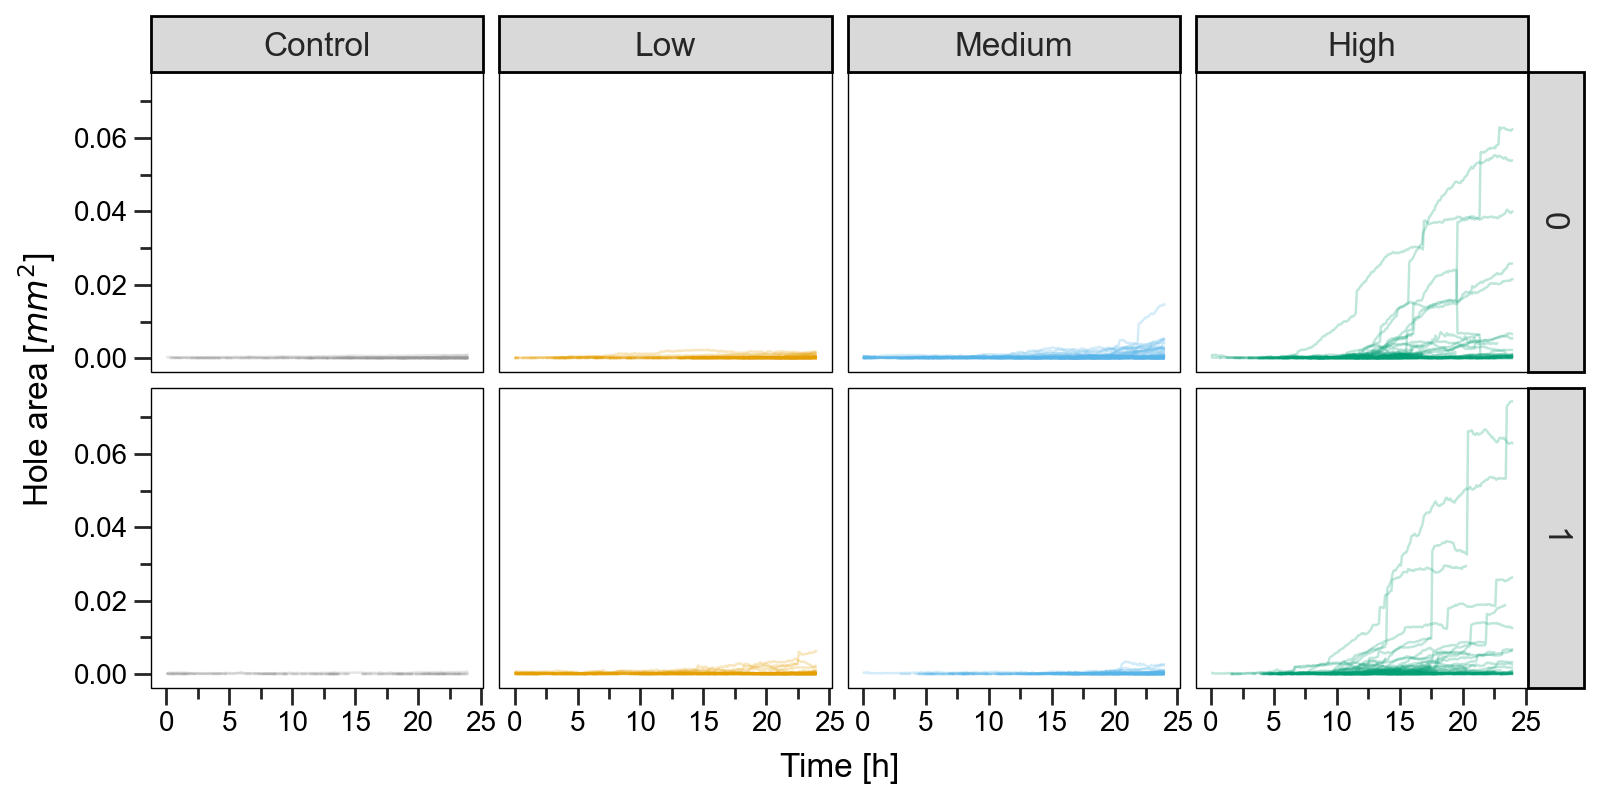

In [56]:
p_hole_area_per_fov = (p9.ggplot(df_holes_props,
          p9.aes(x = 'time_h',
                 y = 'area_mm2',
                 group = 'label'))
+ p9.geom_line(p9.aes(color = 'condition'), 
               alpha = 0.25)
+ p9.scale_color_manual(name = 'Condition', values=cbPalette)
+ p9.facet_grid('fov_index', 'condition')
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole area [$mm^2$]')
+ p9.theme(legend_position='none',
              figure_size=(8, 4),
              panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12))
)

p_hole_area_per_fov

In [58]:
p9.ggsave(p_hole_area_per_fov, 
          os.path.join(DIR_OUT_PLOT, "hole_area_per_fov.pdf"), 
          width = 8, 
          height = 4)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 4 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_area_per_fov.pdf


## Hole area over time

From both FOVs

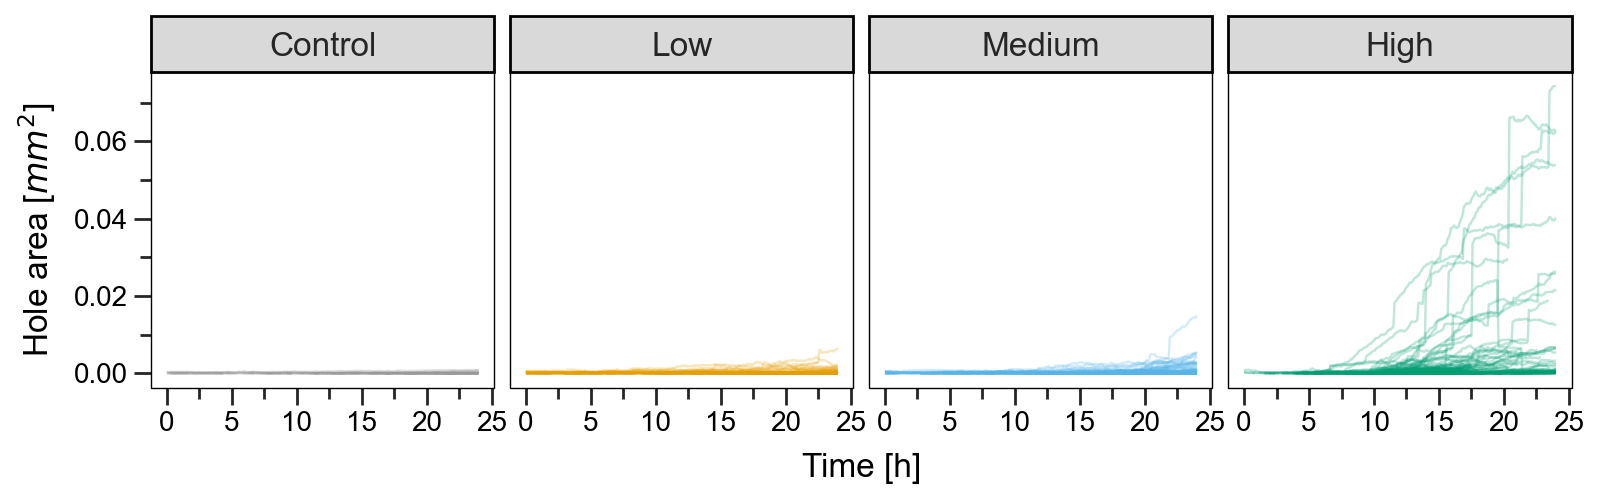

In [57]:
p_hole_area = (p9.ggplot(df_holes_props,
          p9.aes(x = 'time_h',
                 y = 'area_mm2',
                 group = 'fov_label'))
+ p9.geom_line(p9.aes(color = 'condition'), 
               alpha = 0.25)
+ p9.scale_color_manual(name = 'Condition', values=cbPalette)
+ p9.facet_wrap('condition', nrow = 1)
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole area [$mm^2$]')
+ p9.theme(legend_position='none',
            figure_size=(8, 2.5),
            panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12)))

p_hole_area

In [59]:
p9.ggsave(p_hole_area, 
          os.path.join(DIR_OUT_PLOT, "hole_area.pdf"), 
          width = 8, height = 2.5)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 2.5 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_area.pdf


In [24]:
df_holes_props[df_holes_props['time_h'] == 10]

,label,area,frame,fov,condition,time_h,area_um2,area_mm2,fov_index,fov_label
0,2,1104.0,120,0,Control,10.0,452.1984,0.000452,0,0_2
1,3,224.0,120,0,Control,10.0,91.7504,0.000092,0,0_3
2,20,112.0,120,0,Control,10.0,45.8752,0.000046,0,0_20
3,24,448.0,120,0,Control,10.0,183.5008,0.000184,0,0_24
0,4,736.0,120,1,Control,10.0,301.4656,0.000301,1,1_4
...,...,...,...,...,...,...,...,...,...,...
44,211,208.0,120,7,High,10.0,85.1968,0.000085,1,7_211
45,216,160.0,120,7,High,10.0,65.5360,0.000066,1,7_216
46,217,96.0,120,7,High,10.0,39.3216,0.000039,1,7_217
47,224,224.0,120,7,High,10.0,91.7504,0.000092,1,7_224


In [60]:
# Aggregate df_holes_props to calculate the total area_mm2 per condition, fov, and frame
df_holes_aggr = df_holes_props.groupby(['condition', 'frame'], observed=True)['area_mm2'].sum().reset_index()
df_holes_aggr['area_mm2_frac'] = df_holes_aggr['area_mm2'] / (2*.00064**2 * 1024**2)
df_holes_aggr['time_h'] = df_holes_aggr['frame'] * SAMPLE_PERIOD_MIN/60
df_holes_aggr


,condition,frame,area_mm2,area_mm2_frac,time_h
0,Control,0,0.000976,0.001137,0.000000
1,Control,1,0.000931,0.001083,0.083333
2,Control,2,0.000918,0.001068,0.166667
3,Control,3,0.001199,0.001396,0.250000
4,Control,4,0.001016,0.001183,0.333333
...,...,...,...,...,...
1151,High,284,0.424293,0.493942,23.666667
1152,High,285,0.424437,0.494110,23.750000
1153,High,286,0.425420,0.495255,23.833333
1154,High,287,0.427033,0.497131,23.916667


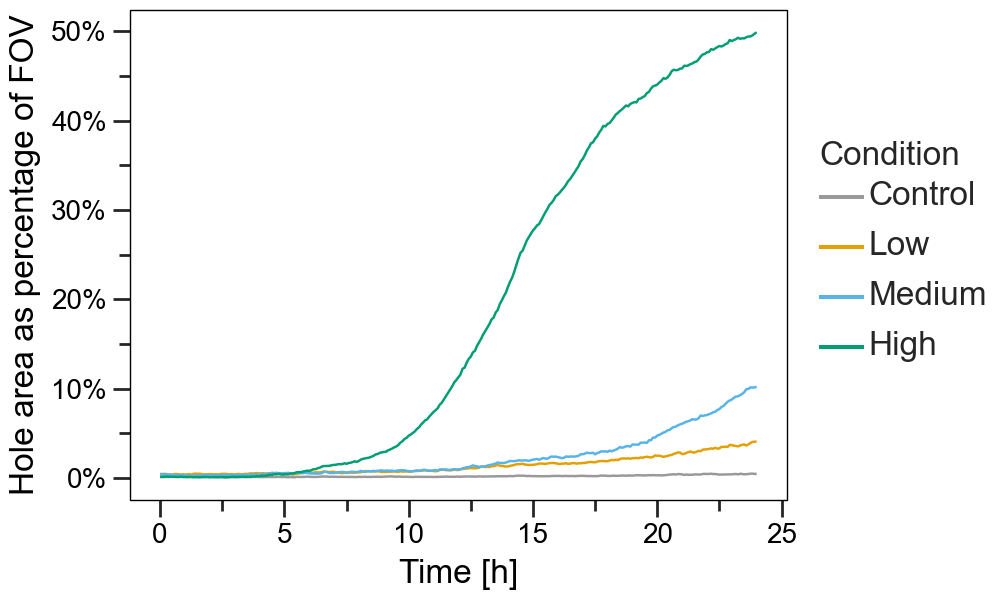

In [61]:
p_hole_area_perc = (p9.ggplot(df_holes_aggr,
          p9.aes(x = "time_h",
                 y = "area_mm2_frac"))
+ p9.geom_line(p9.aes(color = 'condition'), 
               alpha = 1)
+ p9.scale_color_manual(name = 'Condition', values=cbPalette)
+ p9.scale_y_continuous(labels=percent_format())
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole area as percentage of FOV')
+ p9.theme(legend_position='right',
            figure_size=(5, 3),
            panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12))              
)

p_hole_area_perc

Area occupied by holes at the end of acquisition

In [62]:
df_holes_aggr[df_holes_aggr['time_h'] >= 24]

,condition,frame,area_mm2,area_mm2_frac,time_h
288,Control,288,0.004103,0.004776,24.0
577,Low,288,0.035239,0.041023,24.0
866,Medium,288,0.087628,0.102013,24.0
1155,High,288,0.428422,0.498749,24.0


In [63]:
p9.ggsave(p_hole_area_perc, 
          os.path.join(DIR_OUT_PLOT, "hole_area_perc_fov.pdf"), 
          width = 5, height = 3)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 5 x 3 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_area_perc_fov.pdf


## Hole count over time

In [68]:
df_hole_counts

,condition,frame,counts,time_h
0,Control,0,5,0.000000
1,Control,1,5,0.083333
2,Control,2,6,0.166667
3,Control,3,6,0.250000
4,Control,4,8,0.333333
...,...,...,...,...
1151,High,284,46,23.666667
1152,High,285,45,23.750000
1153,High,286,46,23.833333
1154,High,287,45,23.916667


In [64]:
df_hole_counts = df_holes_props.groupby(['condition', 'frame'], observed=True).size().reset_index(name='counts')

# sort holes according to condition
df_hole_counts['condition'] = pd.Categorical(df_hole_counts['condition'], v_cond_order)
df_hole_counts = df_hole_counts.sort_values(by = ['condition', 'frame'])

# Add a column with time in hours
df_hole_counts['time_h'] = df_hole_counts['frame'] * SAMPLE_PERIOD_MIN/60
df_hole_counts[df_hole_counts['time_h'] == 10]

,condition,frame,counts,time_h
120,Control,120,5,10.0
409,Low,120,25,10.0
698,Medium,120,32,10.0
987,High,120,84,10.0


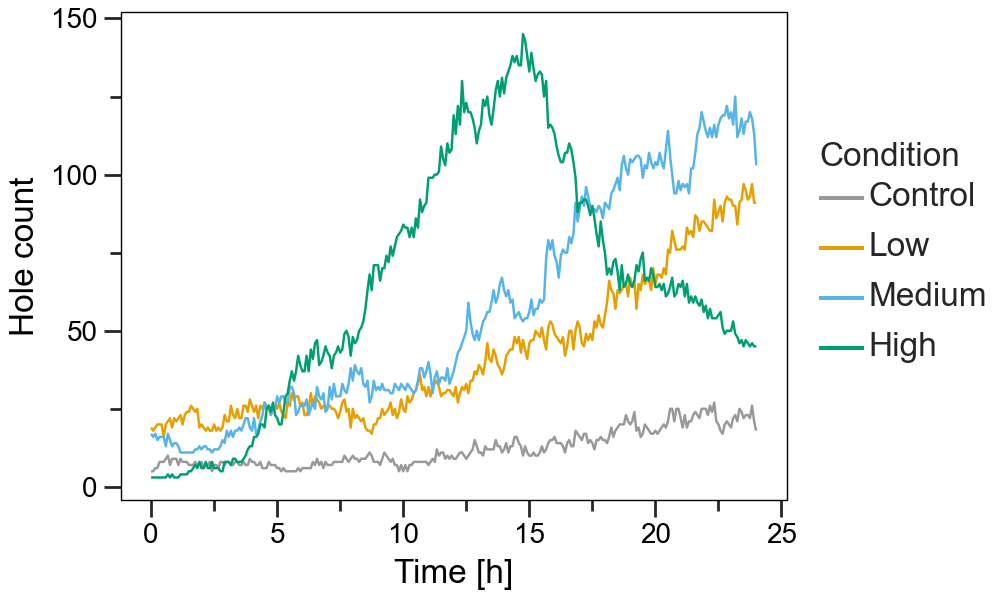

In [65]:
p_hole_count = (p9.ggplot(df_hole_counts,
          p9.aes(x = "time_h",
                 y = "counts"))
+ p9.geom_path(p9.aes(color = 'condition'), 
               alpha = 1)
+ p9.scale_color_manual(name = 'Condition', 
                            values=cbPalette)
+ p9.theme_matplotlib()
+ p9.xlab('Time [h]')
+ p9.ylab('Hole count')
+ p9.theme(legend_position='right',
            figure_size=(5, 3),
            panel_grid=p9.element_blank(),
              panel_border=p9.element_rect(size=0.5, colour="black"),
              panel_background=p9.element_blank(),
              text=p9.element_text(family="Arial"),
              axis_text_x=p9.element_text(colour="black", size=10),
              axis_text_y=p9.element_text(colour="black", size=10),
              axis_title_x=p9.element_text(colour="black", size=12),
              axis_title_y=p9.element_text(colour="black", size=12))
)

p_hole_count

In [66]:
p9.ggsave(p_hole_count, 
          os.path.join(DIR_OUT_PLOT, "hole_count.pdf"),           
          width = 5, height = 3)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 5 x 3 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_count.pdf


## Rate of hole formation

In [71]:
df_area_diff = df_holes_props.groupby(['condition', 'fov', 'label'], observed=True)['area_um2'].agg(lambda x: x.iloc[-1] - x.iloc[0]).reset_index(name='area_um2_diff')
df_time_diff = df_holes_props.groupby(['condition', 'fov', 'label'], observed=True)['time_h'].agg(lambda x: (x.iloc[-1] - x.iloc[0])*3600).reset_index(name='time_s_diff')

df_holes_speed = pd.merge(df_area_diff, df_time_diff, on=['condition', 'fov', 'label'], how='inner')
df_holes_speed['speed_um2_s'] = df_holes_speed['area_um2_diff'] /  df_holes_speed['time_s_diff']
df_holes_speed


,condition,fov,label,area_um2_diff,time_s_diff,speed_um2_s
0,Control,0,2,570.1632,86400.0,0.006599
1,Control,0,3,-6.5536,53700.0,-0.000122
2,Control,0,4,0.0000,12900.0,0.000000
3,Control,0,5,13.1072,2100.0,0.006242
4,Control,0,7,-6.5536,8400.0,-0.000780
...,...,...,...,...,...,...
2639,High,7,785,255.5904,2400.0,0.106496
2640,High,7,786,0.0000,600.0,0.000000
2641,High,7,788,668.4672,1800.0,0.371371
2642,High,7,790,176.9472,1500.0,0.117965


### Total hole time difference vs total area difference

Each dot corresponds to a single hole.

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_17200/3283053168.py:9: SyntaxWarning: invalid escape sequence '\m'


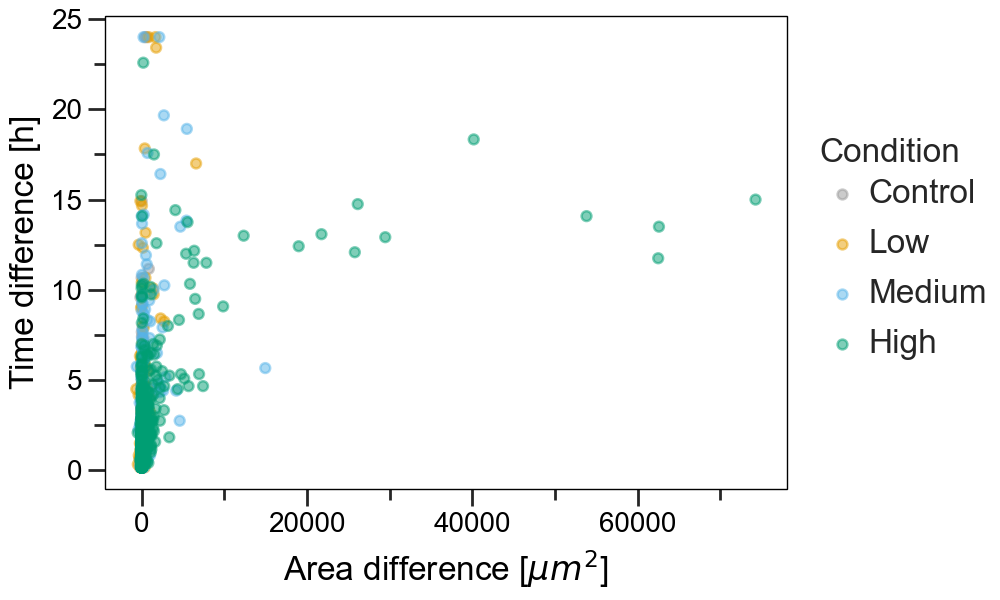

In [72]:
p_hole_areadiff_vs_timediff = (p9.ggplot(df_holes_speed,
           p9.aes(x = 'time_s_diff / 3600',
                  y = 'area_um2_diff',
                  color = 'condition'))
    + p9.geom_point(alpha = 0.5)
    + p9.scale_color_manual(name = 'Condition', values=cbPalette) 
    + p9.coord_flip()
    + p9.xlab("Time difference [h]")
    + p9.ylab("Area difference [$\mu m^2$]")
#    + p9.theme_bw()
    + p9.theme_matplotlib()
    + p9.theme(
        legend_position='right',
        figure_size=(5, 3),
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

p_hole_areadiff_vs_timediff

### The number of shrinking and growing holes

In [73]:
# Calculate the number of shrinking (negative rate) and growing (positive rate) holes
df_holes_speed['speed_positive'] = df_holes_speed['speed_um2_s'] > 0
df_holes_speed['speed_negative'] = df_holes_speed['speed_um2_s'] <= 0

df_holes_speed_aggr = df_holes_speed.groupby('condition').agg({
    'speed_positive': 'sum',
    'speed_negative': 'sum'
})

df_holes_speed_aggr['speed_negative_perc'] = df_holes_speed_aggr['speed_negative'] / (df_holes_speed_aggr['speed_negative'] + df_holes_speed_aggr['speed_positive']) * 100
df_holes_speed_aggr

/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_17200/2170554909.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,speed_positive,speed_negative,speed_negative_perc
condition,,,
Control,74,101,57.714286
Low,377,375,49.867021
Medium,493,391,44.230769
High,539,294,35.294118


### Rate of hole formation

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_17200/3542031767.py:12: SyntaxWarning: invalid escape sequence '\m'


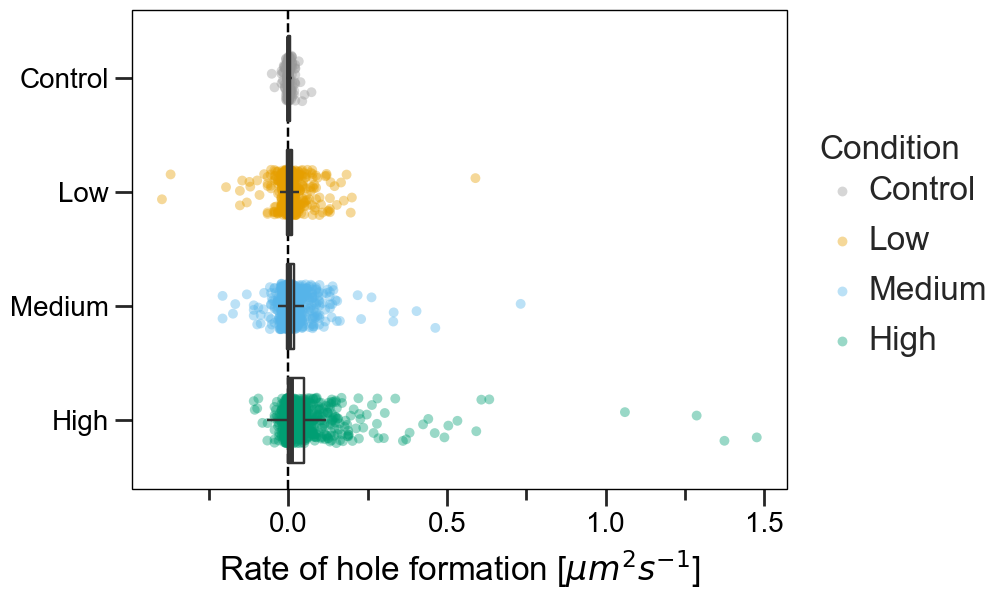

In [74]:
p_hole_speed = (p9.ggplot(df_holes_speed,
           p9.aes(y = 'speed_um2_s',
                  x = 'condition',
                  fill = 'condition'))
#    + p9.geom_dotplot(stackdir = "center", binaxis = "y", position = "dodge", binpositions="all", binwidth = 0.07)
    + p9.geom_hline(yintercept = 0, linetype = "dashed")
    + p9.geom_jitter(alpha=.4, width = 0.2, height = 0., stroke = 0, size = 2)
    + p9.geom_boxplot(fill = 'none', outlier_color = 'none')
    + p9.scale_fill_manual(name = 'Condition', values=cbPalette)
    + p9.coord_flip()
    + p9.scale_x_discrete(limits = v_cond_order[::-1])
    + p9.ylab("Rate of hole formation [$\mu m^2 s^{-1}$]")
    + p9.xlab("")
#    + p9.theme_bw()
    + p9.theme_matplotlib()
    + p9.theme(
        legend_position='right',
        figure_size=(5, 3),
        panel_grid=p9.element_blank(),
        panel_border=p9.element_rect(size=0.5, colour="black"),
        panel_background=p9.element_blank(),
        text=p9.element_text(family="Arial"),
        axis_text_x=p9.element_text(colour="black", size=10),
        axis_text_y=p9.element_text(colour="black", size=10),
        axis_title_x=p9.element_text(colour="black", size=12),
        axis_title_y=p9.element_text(colour="black", size=12),
    )
)

p_hole_speed

In [ ]:
p9.ggsave(p_hole_speed,
          os.path.join(DIR_OUT_PLOT, "hole_speed_dotplot.pdf"),  
          width = 4, height = 2)

/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 2 in image.
/Users/maciekd/miniforge3/envs/arcos_tutorial/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../data/5_hole_tracking/output-plots/hole_speed_dotplot.pdf


## Statistical tests

### Two-sided Wilcoxon and Cohen's d

In [75]:
conditions = df_holes_speed['condition'].unique()
condition_data = {cond: df_holes_speed[df_holes_speed['condition'] == cond]['speed_um2_s'].values for cond in conditions}

wilcoxon_results = []
cohens_d_results = []

for i, cond1 in enumerate(conditions):
    for cond2 in conditions[i+1:]:
        # Wilcoxon test
        data1 = condition_data[cond1]
        data2 = condition_data[cond2]
        
        try:
            stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            wilcoxon_results.append({
                'condition1': cond1,
                'condition2': cond2,
                'wilcoxon_statistic': stat,
                'p_value': p_value
            })
            
            # Cohen's d effect size
            mean1, mean2 = np.mean(data1), np.mean(data2)
            var1, var2 = np.var(data1, ddof=1), np.var(data2, ddof=1)
            n1, n2 = len(data1), len(data2)
            
            # Pooled standard deviation
            pooled_sd = math.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
            
            # Cohen's d
            cohens_d = (mean1 - mean2) / pooled_sd
            
            cohens_d_results.append({
                'condition1': cond1,
                'condition2': cond2,
                'cohens_d': cohens_d,
                'effect_size_interpretation': interpret_cohens_d(cohens_d)
            })
        except ValueError as e:
            wilcoxon_results.append({
                'condition1': cond1,
                'condition2': cond2,
                'error': str(e)
            })
            cohens_d_results.append({
                'condition1': cond1,
                'condition2': cond2,
                'error': str(e)
            })

wilcoxon_df = pd.DataFrame(wilcoxon_results)
cohens_d_df = pd.DataFrame(cohens_d_results)

In [76]:
wilcoxon_df

,condition1,condition2,wilcoxon_statistic,p_value
0,Control,Low,60899.5,1.232303e-01
1,Control,Medium,65915.0,1.945905e-03
2,Control,High,48039.5,1.163474e-12
3,Low,Medium,308881.0,1.344117e-02
4,Low,High,230564.0,9.252743e-20
5,Medium,High,296014.5,1.979638e-12


In [77]:
cohens_d_df

,condition1,condition2,cohens_d,effect_size_interpretation
0,Control,Low,-0.090839,negligible
1,Control,Medium,-0.219026,small
2,Control,High,-0.375250,small
3,Low,Medium,-0.137006,negligible
4,Low,High,-0.401939,small
5,Medium,High,-0.331492,small


### CI for the median

Calculated from bootstrapping

In [78]:
# Dictionary to store results
ci_results = []

# Calculate median and CI for each condition
for cond in conditions:
    values = df_holes_speed[df_holes_speed['condition'] == cond]['speed_um2_s'].values
    median, lower, upper = median_confidence_interval(values, 
                                                      method='bootstrap', 
                                                      confidence=0.95, 
                                                      n_bootstrap=1000)
    
    ci_results.append({
        'condition': cond,
        'count': len(values),
        'median': median,
        'ci_lower': lower,
        'ci_upper': upper,
        'ci_width': upper - lower
    })

# Convert to DataFrame
ci_df = pd.DataFrame(ci_results)

# Calculate additional summary statistics
ci_df['mean'] = [df_holes_speed[df_holes_speed['condition'] == cond]['speed_um2_s'].mean() for cond in ci_df['condition']]
ci_df['std'] = [df_holes_speed[df_holes_speed['condition'] == cond]['speed_um2_s'].std() for cond in ci_df['condition']]
ci_df

,condition,count,median,ci_lower,ci_upper,ci_width,mean,std
0,Control,175,0.000000,0.000000,0.000000,0.000000,0.001857,0.012427
1,Low,752,0.000252,0.000000,0.001701,0.001701,0.005585,0.045151
2,Medium,884,0.002447,0.001455,0.003641,0.002186,0.012274,0.051743
3,High,833,0.008495,0.005461,0.010923,0.005461,0.042166,0.117983
